This purpose of this notebook is to automatically identify which features are highly correlated with each other and systematically remove them

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

NSCH19 = pd.read_sas("data/nsch_2019e_topical.sas7bdat")

from sklearn.model_selection import train_test_split
from NSCH_helpers import impute_NSCH, clean_NSCH

In [4]:
# Defining the cleaned data set.  We drop columns that don't make sense to investigate correlation with.

clean_NSCH19 = clean_NSCH(NSCH19)
drop_cols = ['STATE', 'ABBR', 'FIPSST', 'days_missed']
clean_NSCH19 = clean_NSCH19.drop(drop_cols, axis = 1)

In [5]:
# This creates a serise with values equal to the correlation of the multiindex of a pair of features.  
# Note that the absolute value of the correlation is considered.  We remove instances of pairs with the same feature by only looking at
# correlation values of < 1.
corr_series = clean_NSCH19.corr().unstack()
corr_series = corr_series.loc[corr_series < 1]
corr_series = corr_series.apply(abs)
corr_series = corr_series.sort_values()


In [6]:
# This creates a new multi-index which is sorted.  This will help in removing duplicates.
new_index = pd.MultiIndex.from_tuples([tuple(sorted(pair)) for pair in corr_series.index], names=corr_series.index.names)
# This reassigns the index of corr_series
corr_series.index = new_index
# This removes duplicate indices
corr_series =corr_series[~corr_series.index.duplicated(keep = 'first')]

In [7]:
# This creates a series with high correlation as defined by threshold
threshold = 0.8
high_corr_series = corr_series[corr_series.values >= threshold]

## Visualizing Correlated Features

We will visualize correlation via a weighted graph.

In [8]:
# Creating the edges (indices) and weights (correlations)
weights = [round(corr,2) for corr in high_corr_series.values]
edges = [index for index in high_corr_series.index]
edges_with_weights = list(zip(edges, weights))

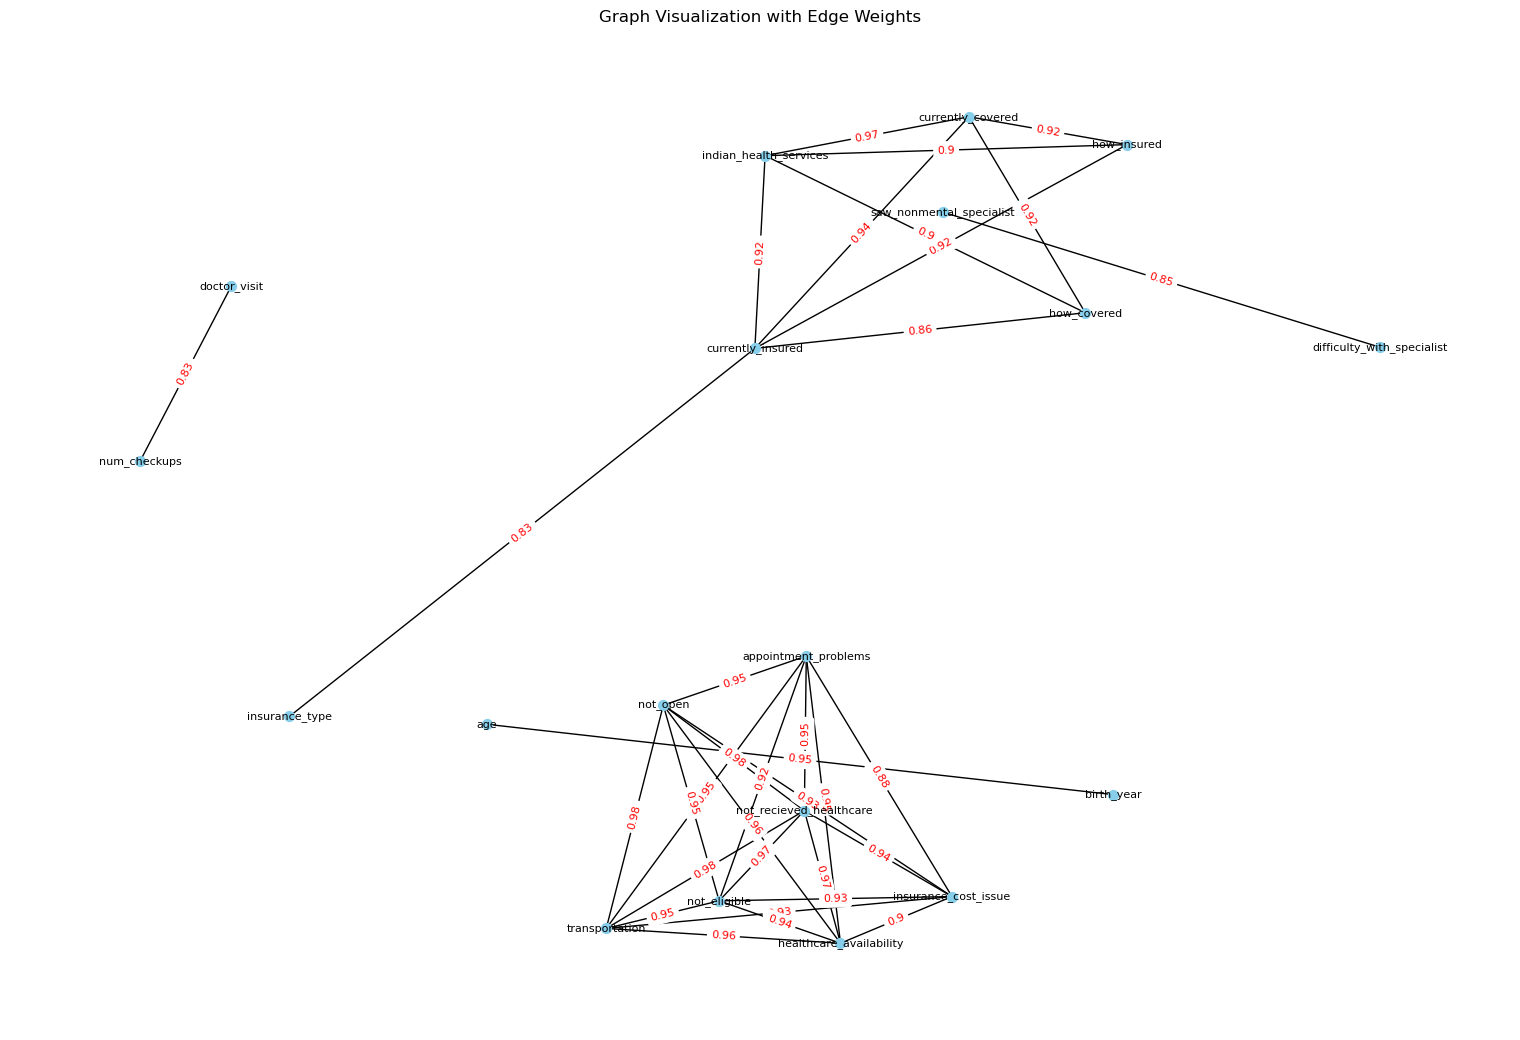

In [9]:
# This creates a graph from our edge_with_weights and visuializes the graph.
G = nx.Graph()

for edge, weight in edges_with_weights:
    G.add_edge(edge[0], edge[1], weight=weight)

pos = nx.spring_layout(G, k=1.2)
plt.figure(figsize=(15,10))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='r')

plt.title("Graph Visualization with Edge Weights")
plt.show()


In [28]:
# This function calculates the percent of missing entries given a dataframe df and the column name
def percent_missing(df, column_name): return df[column_name].isnull().sum()/len(df[column_name])

In [45]:
# These are the two large clusters from the above graph.
cluster_1 = ['how_covered', 'indian_health_services', 'currently_insured', 'insurance_type', 'currently_covered', 'how_insured']
cluster_2 = ['not_recieved_healthcare', 'appointment_problems', 'healthcare_availability', 
             'not_open', 'insurance_cost_issue', 'not_eligible', 'transportation']

In [48]:
for col in cluster_2:
    print(f'feature {col} has', percent_missing(clean_NSCH19, col), '% missing data')

feature not_recieved_healthcare has 0.0030096020637271296 % missing data
feature appointment_problems has 0.0032484593703721396 % missing data
feature healthcare_availability has 0.0032484593703721396 % missing data
feature not_open has 0.0032484593703721396 % missing data
feature insurance_cost_issue has 0.0032484593703721396 % missing data
feature not_eligible has 0.0032484593703721396 % missing data
feature transportation has 0.0032484593703721396 % missing data


Based on this, we should **drop** the following features:

The following appeared in clusters of 2
- 'num_checkups' (this has more missing data than 'doctor_visit')
- 'birth_year' (this has more missing data than 'age')
- 'saw_nonmental_specialist' ('difficulty_with_specialist' is more related to healthcare access)

We should **keep** the following features in their respective cluster:
- 'currently_insured' (most directly related to healthcare access and is connected to all other features in cluster)



## Examining Correlation for Imputed Data

In [10]:
# We originally removed some columns from clean_NSCH19, so we have to reimport it.  In particular, 
# impute_NSCH will break if we don't have the FIPSST column.
clean_NSCH19_1 = clean_NSCH(NSCH19)
df_train, df_test = train_test_split(clean_NSCH19_1, test_size = 0.2)

In [12]:
# Imputed training data
imputed_df_train = impute_NSCH(df_train, imputer = 'rf')

In [13]:
# Imputed testing data (this isn't needed, so ignore)
#imputed_df_test = impute_NSCH(df_train, imputer = 'rf', test = True, test_data = df_test)

In [22]:
## This is the same code as above, where we create a series of highly correlated features.
imp_corr_series = imputed_df_train.drop([col for col in drop_cols if col in imputed_df_train.columns], axis = 1)
imp_corr_series = imp_corr_series.corr().unstack()
imp_corr_series = imp_corr_series.loc[imp_corr_series < 1]
imp_corr_series = imp_corr_series.apply(abs)
imp_corr_series = imp_corr_series.sort_values()
imp_new_index = pd.MultiIndex.from_tuples([tuple(sorted(pair)) for pair in imp_corr_series.index], names=imp_corr_series.index.names)
imp_corr_series.index = imp_new_index
imp_corr_series =imp_corr_series[~imp_corr_series.index.duplicated(keep = 'first')]


In [24]:
threshold = 0.8
imp_high_corr_series = imp_corr_series[imp_corr_series.values >= threshold]

In [26]:
# Visualizing correlation among the imputed training data
# Creating the edges (indices) and weights (correlations)
imp_weights = [round(corr,2) for corr in imp_high_corr_series.values]
imp_edges = [index for index in imp_high_corr_series.index]
imp_edges_with_weights = list(zip(edges, weights))

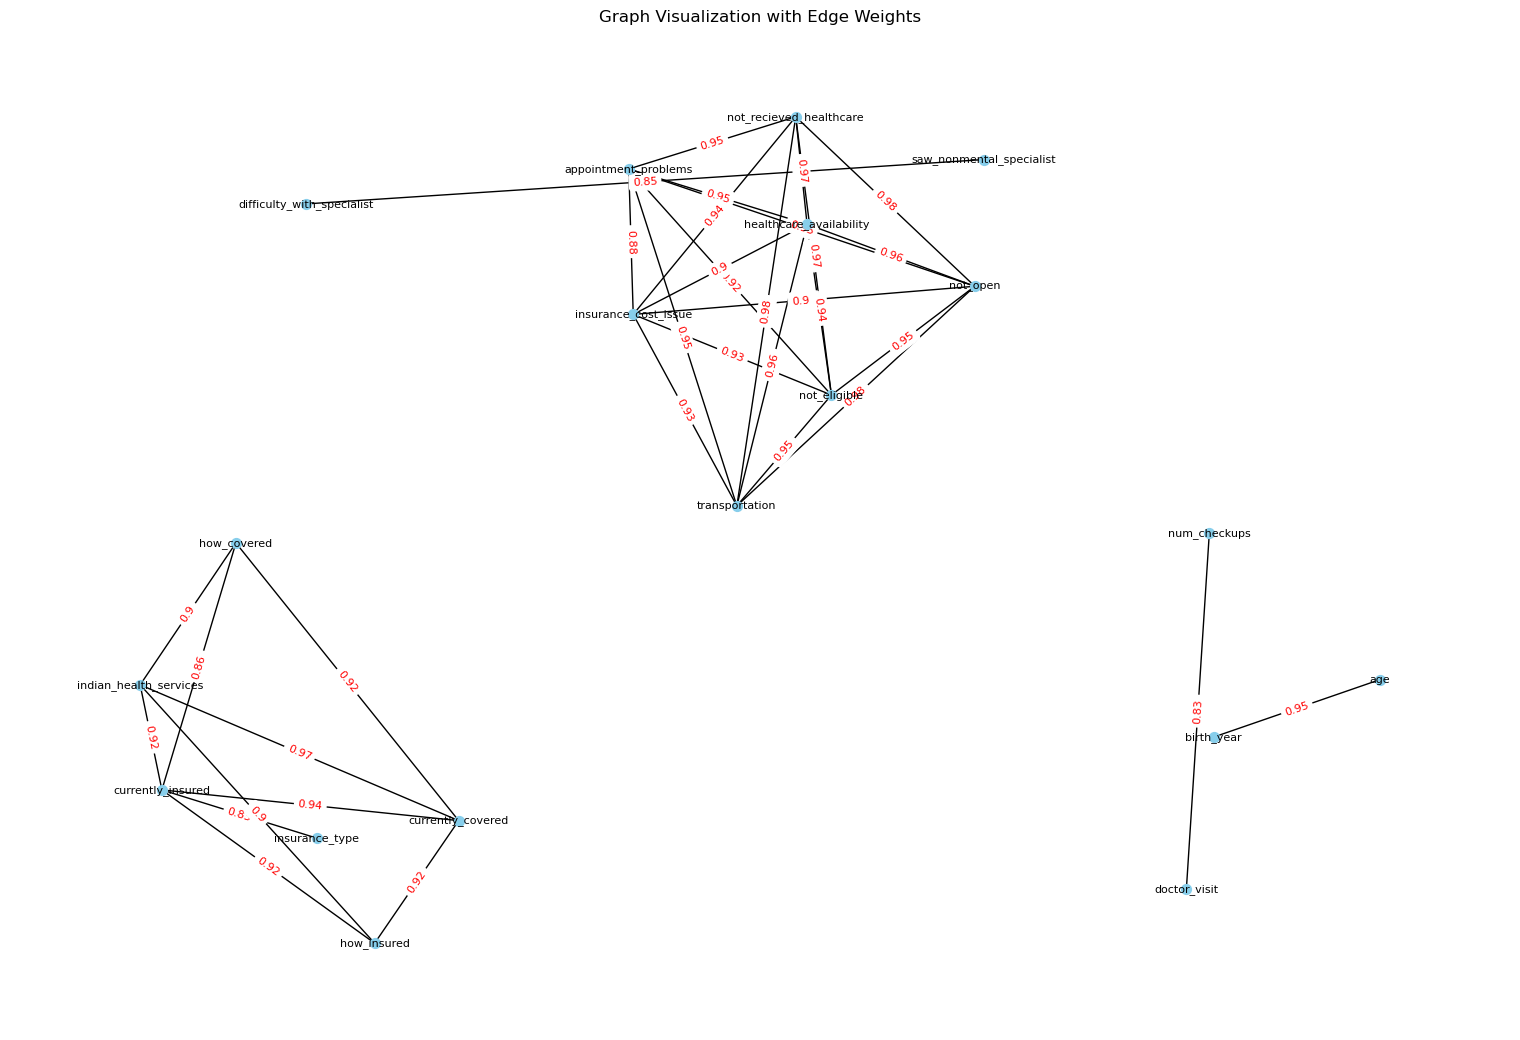

In [27]:
G = nx.Graph()

for edge, weight in imp_edges_with_weights:
    G.add_edge(edge[0], edge[1], weight=weight)

pos = nx.spring_layout(G, k=1.2)
plt.figure(figsize=(15,10))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='r')

plt.title("Graph Visualization with Edge Weights")
plt.show()

The above graph is the same with the graph corresponding to the cleaned data.  Therefore, the imputed data doesn't reveal any new or lost correlation relationships.